# GAIA Service Tests

This notebook focuses on testing the performance of GAIA's query services.

## Asynchronous Tests

By using asynchronous tests it is possible to measure the times between different phases of a query request (PENDING, EXECUTING, COMPLETED, etc).

### Simples Query on Repeat

The first test comprises a series of query requests with the same prompt, except for the limit value (in which the value increases with each request).

For each request, we measure 4 different time periods: query submission, job start, job execution, and data fetch.

In [2]:
from dataclasses import dataclass
import matplotlib.pyplot as plt
import numpy as np
import requests
import pyvo
import time

s_url_gaia = "https://gaia.aip.de/tap"

q_name = "test_service"
q_time = "30s"
lang = "PostgreSQL"

query_gaia = """
SELECT osc_epoch, orb_m, omega, node_omega, inclination, eccentricity, a
FROM gaiadr2.aux_sso_orbits
LIMIT 100
"""

tap_session = requests.Session()
tap_service = pyvo.dal.TAPService(s_url_gaia, session=tap_session)

job = tap_service.submit_job(query_gaia, language=lang, runid=q_name, queue=q_time)

print(job.url)
print(job.job_id)
print(job.query)
print(job.phase)

job.delete()

https://gaia.aip.de/tap/async/29de4f79-f244-4553-a16f-ec9791ff4d8e
29de4f79-f244-4553-a16f-ec9791ff4d8e
SELECT osc_epoch, orb_m, omega, node_omega, inclination, eccentricity, a
FROM gaiadr2.aux_sso_orbits
LIMIT 100
PENDING


 >>> SUBMIT
AVG: 2.7286993789672853
STD: 0.12044452623864704
 >>> RUN
AVG: 1.3247961559295656
STD: 0.10501480361791705
 >>> EXECUTE
AVG: 0.3664261999130249
STD: 0.06352011352768253
 >>> FETCH
AVG: 6.515735072612761
STD: 0.489149520480577


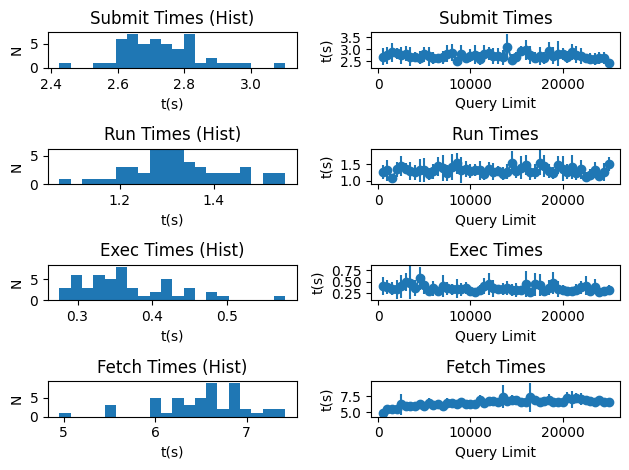

In [12]:
from dataclasses import dataclass
import matplotlib.pyplot as plt
import numpy as np
import requests
import pyvo
import time

s_url_gaia = "https://gaia.aip.de/tap"

q_name = "test_service"
q_time = "30s"

query_gaia = """
SELECT osc_epoch, orb_m, omega, node_omega, inclination, eccentricity, a
FROM gaiadr2.aux_sso_orbits
LIMIT {0}
"""

@dataclass(frozen=True)
class QueryStats:
    t_submit: float
    t_submit_std: float
    t_run: float
    t_run_std: float
    t_exec: float
    t_exec_std: float
    t_fetch: float
    t_fetch_std: float

def time_query(query: str, query_name: str, query_time: str, url: str, query_lang: str = "PostgreSQL") -> QueryStats:

    tap_session = requests.Session()
    tap_service = pyvo.dal.TAPService(url, session=tap_session)

    t_start = time.time()
    job = tap_service.submit_job(query, language=query_lang, runid=query_name, queue=query_time)
    t_after_submiting = time.time()

    job.run()
    t_after_run = time.time()

    job.wait(phases=["COMPLETED", "ERROR", "ABORTED"], timeout=30)
    t_after_execution = time.time()

    job.raise_if_error()

    t_before_fetch = time.time()
    _ = job.fetch_result()
    t_after_fetch = time.time()

    submit_time = t_after_submiting - t_start
    run_time = t_after_run - t_after_submiting
    exec_time = t_after_execution - t_after_run
    fetch_time = t_after_fetch - t_before_fetch
    stats = QueryStats(submit_time, 0., run_time, 0., exec_time, 0., fetch_time, 0.)

    job.delete()
    return stats

def print_with_average(phase: str, list_values: float) -> None:
    print(f" >>> {phase.upper()}")
    print(f"AVG: {np.mean(list_values)}")
    print(f"STD: {np.std(list_values)}")

# Run a few tests with the same query string (except for different limits)
stats_dict = dict()
for i in range(1, 51):
    limit_value = 500 * i
    query = query_gaia.format(limit_value)

    submit_list = []
    run_list = []
    exec_list = []
    fetch_list = []

    for i in range(10):
        try:
            query_stats = time_query(query, q_name, q_time, s_url_gaia)
        except pyvo.dal.DALQueryError as e:
            print(f"Exception raised with limit {i*100}")
            continue
        except Exception as e:
            print(f"Exception '{e}' raised with limit {i*100}")
            continue

        submit_list.append(query_stats.t_submit)
        run_list.append(query_stats.t_run)
        exec_list.append(query_stats.t_exec)
        fetch_list.append(query_stats.t_fetch)

    if len(submit_list) > 0:
        avg_stats = QueryStats(np.mean(submit_list), np.std(submit_list),
                            np.mean(run_list), np.std(run_list),
                            np.mean(exec_list), np.std(exec_list),
                            np.mean(fetch_list), np.std(fetch_list))
        
        stats_dict[limit_value] = avg_stats

# Get lists of values for different phases

limit_values = []
submit_times = []
submit_times_std = []
run_times = []
run_times_std = []
exec_times = []
exec_times_std = []
fetch_times = []
fetch_times_std = []

for key, query_result in stats_dict.items():
    limit_values.append(key)
    submit_times.append(query_result.t_submit)
    submit_times_std.append(query_result.t_submit_std)
    run_times.append(query_result.t_run)
    run_times_std.append(query_result.t_run_std)
    exec_times.append(query_result.t_exec)
    exec_times_std.append(query_result.t_exec_std)
    fetch_times.append(query_result.t_fetch)
    fetch_times_std.append(query_result.t_fetch_std)


# Print values
print_with_average("submit", submit_times)
print_with_average("run", run_times)
print_with_average("execute", exec_times)
print_with_average("fetch", fetch_times)

# Images
bin_size = 20

plt.subplot(421)
plt.hist(submit_times, bins=bin_size)
plt.title("Submit Times (Hist)")
plt.xlabel("t(s)")
plt.ylabel("N")

plt.subplot(422)
plt.errorbar(limit_values, submit_times, yerr=submit_times_std, fmt="-o")
plt.title("Submit Times")
plt.xlabel("Query Limit")
plt.ylabel("t(s)")

plt.subplot(423)
plt.hist(run_times, bins=bin_size)
plt.title("Run Times (Hist)")
plt.xlabel("t(s)")
plt.ylabel("N")

plt.subplot(424)
plt.errorbar(limit_values, run_times, yerr=run_times_std, fmt="-o")
plt.title("Run Times")
plt.xlabel("Query Limit")
plt.ylabel("t(s)")

plt.subplot(425)
plt.hist(exec_times, bins=bin_size)
plt.title("Exec Times (Hist)")
plt.xlabel("t(s)")
plt.ylabel("N")

plt.subplot(426)
plt.errorbar(limit_values, exec_times, yerr=exec_times_std, fmt="-o")
plt.title("Exec Times")
plt.xlabel("Query Limit")
plt.ylabel("t(s)")

plt.subplot(427)
plt.hist(fetch_times, bins=bin_size)
plt.title("Fetch Times (Hist)")
plt.xlabel("t(s)")
plt.ylabel("N")

plt.subplot(428)
plt.errorbar(limit_values, fetch_times, yerr=fetch_times_std, fmt="-o")
plt.title("Fetch Times")
plt.xlabel("Query Limit")
plt.ylabel("t(s)")

plt.tight_layout()

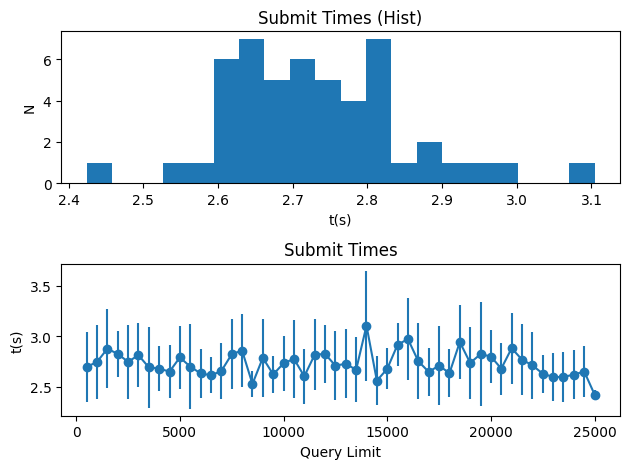

In [20]:
plt.subplot(211)
plt.hist(submit_times, bins=bin_size)
plt.title("Submit Times (Hist)")
plt.xlabel("t(s)")
plt.ylabel("N")

plt.subplot(212)
plt.errorbar(limit_values, submit_times, yerr=submit_times_std, fmt="-o")
plt.title("Submit Times")
plt.xlabel("Query Limit")
plt.ylabel("t(s)")

plt.tight_layout()

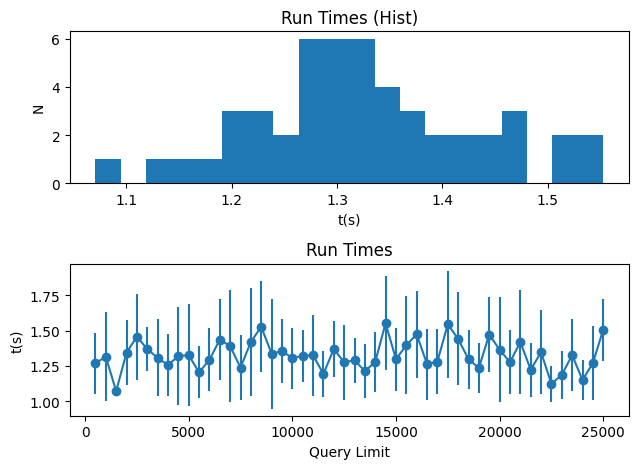

In [21]:
plt.subplot(211)
plt.hist(run_times, bins=bin_size)
plt.title("Run Times (Hist)")
plt.xlabel("t(s)")
plt.ylabel("N")

plt.subplot(212)
plt.errorbar(limit_values, run_times, yerr=run_times_std, fmt="-o")
plt.title("Run Times")
plt.xlabel("Query Limit")
plt.ylabel("t(s)")

plt.tight_layout()

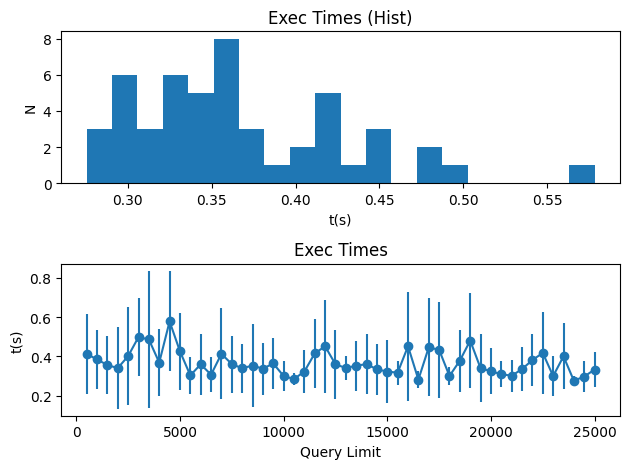

In [16]:
plt.subplot(211)
plt.hist(exec_times, bins=bin_size)
plt.title("Exec Times (Hist)")
plt.xlabel("t(s)")
plt.ylabel("N")

plt.subplot(212)
plt.errorbar(limit_values, exec_times, yerr=exec_times_std, fmt="-o")
plt.title("Exec Times")
plt.xlabel("Query Limit")
plt.ylabel("t(s)")

plt.tight_layout()

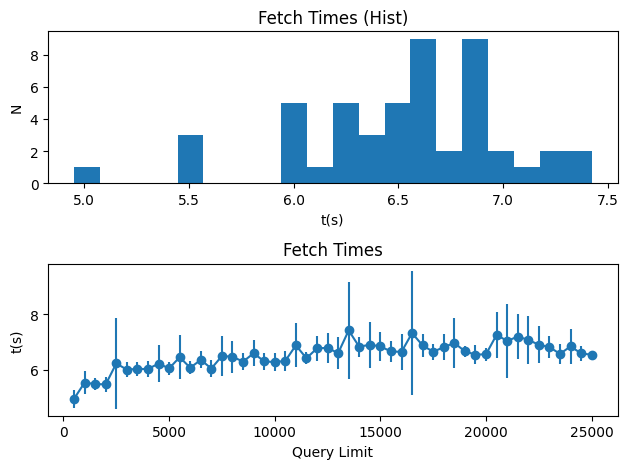

In [17]:
plt.subplot(211)
plt.hist(fetch_times, bins=bin_size)
plt.title("Fetch Times (Hist)")
plt.xlabel("t(s)")
plt.ylabel("N")

plt.subplot(212)
plt.errorbar(limit_values, fetch_times, yerr=fetch_times_std, fmt="-o")
plt.title("Fetch Times")
plt.xlabel("Query Limit")
plt.ylabel("t(s)")

plt.tight_layout()